In [110]:
import torch
import w1d4_tests
import matplotlib.pyplot as plt
w1d4_tests.__dict__.keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'einops', 'plt', 'Image', 'make_moons', 'torch', 'nn', 'F', 'DataLoader', 'TensorDataset', 'torchvision', 'transforms', 'Tuple', 'sol', '_get_moon_data', '_check_equal', 'test_mlp', 'test_train', 'test_accuracy', 'test_evaluate', 'test_rosenbrock', '_train_with_opt', 'test_sgd', 'test_rmsprop', 'test_adam', 'load_image', 'plot_image'])

In [ ]:
data_train, data_test =  w1d4_tests.load_image("cat.jpg")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, P, H, K):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(P, H)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(H, H)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(H, K)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        return x

In [ ]:
w1d4_tests.test_mlp(MLP)

Congrats! You've passed the test.


In [ ]:
def train(model, dataloader, lr, momentum):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    for input, target in dataloader:
        optimizer.zero_grad()
        output = model(input)
        loss = F.l1_loss(output, target)
        loss.backward()
        optimizer.step()
    return model

In [ ]:
w1d4_tests.test_train(train)

Congrats! You've passed the test.


In [ ]:
def evaluate(model, dataloader):
    model.eval()
    losses = []
    for input, target in dataloader:
        output = model(input)
        with torch.no_grad():
            loss = F.l1_loss(output, target)
            losses.append(loss.item())
    return sum(losses)/len(losses)

In [ ]:
w1d4_tests.test_evaluate(evaluate)

Congrats! You've passed the test.


In [ ]:
from PIL import Image
from torchvision import transforms
import einops
img = Image.open("cat.jpg")
tensorize = transforms.ToTensor()
img = tensorize(img)
img = einops.rearrange(img, "c h w -> h w c")
height, width = img.shape[:2]
print(height, width)

1200 1200


In [ ]:
"""
    img = Image.open(fname)
    tensorize = transforms.ToTensor()
    img = tensorize(img)
    img = einops.rearrange(img, "c h w -> h w c")
    height, width = img.shape[:2]
"""
"""
x y -> r g b
"""
i = 0
for x, target in data_train:
    print(x.shape)
    print(target.shape)
    i += 1
    if i == 1:
        break

torch.Size([128, 2])
torch.Size([128, 3])


In [ ]:
model = MLP(2, 400, 3)

In [ ]:
def train(model, data_train, data_test, lr=None, momentum=None, epochs=10, optimizer=None):
    if not optimizer:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    training_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        _training_losses = []
        for input, target in data_train:
            optimizer.zero_grad()
            output = model(input)
            loss = F.l1_loss(output, target)
            _training_losses.append(loss.item())
            loss.backward()
            optimizer.step()
        test_loss = evaluate(model, data_test)
        test_losses.append(test_loss)  
        training_losses.append(sum(_training_losses) / len(_training_losses))
    return model, training_losses, test_losses

In [ ]:
model, training_losses, test_losses = train(model, data_train, data_test, lr=0.01, momentum=0.9, epochs=500)
# print("Training loss:", training_losses)
# print("Test loss:", test_losses)

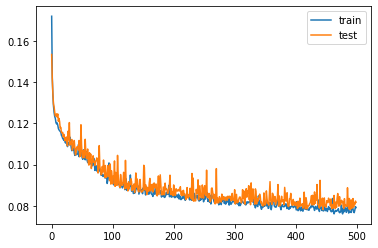

In [ ]:
plt.plot(training_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

In [ ]:
image = torch.zeros(height, width, 3)
model.eval()
for i in range(height):
    x = i / height - .5
    for j in range(width):
        y = j / width - .5
        with torch.no_grad():
            output = model(torch.Tensor([x,y]))
            image[i,j,:] = output + .5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


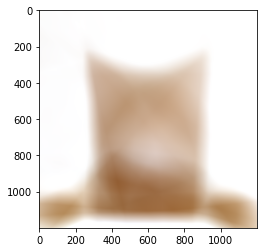

In [ ]:
import matplotlib
matplotlib.pyplot.imshow(image.detach().numpy())

In [ ]:
def banana(x, y, a=1, b=100):
    return (a-x)**2 + b*(y-x**2)**2 + 1

In [ ]:
# takes arrays x, y, z (z of size |x| * |y| ?)
# matplotlib.pyplot.contourf
import numpy as np
xs = torch.linspace(-2, 2, 100)
ys = torch.linspace(-1, 3, 100)
results = torch.zeros(ys.shape[0], xs.shape[0])
for iy, y in enumerate(ys):
    for ix, x in enumerate(xs):
        results[iy,ix] = banana(x, y)

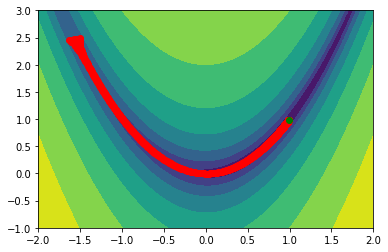

In [ ]:
# def banana(x, y, a=1, b=100):
#     return (a-x)**2 + b*(y-x**2)**2 + 1

def opt_rosenbrock(xy, lr, momentum, n_iter, optimizer=None):
    if not optimizer:
        optimizer = torch.optim.SGD([xy], lr=lr, momentum=momentum)
    xys = torch.zeros(n_iter,2)
    xys[0, :] = xy.detach()
    for i in range(1, n_iter):
        optimizer.zero_grad()
        loss = banana(xy[0], xy[1], a=1)
        loss.backward()
        optimizer.step()
        xys[i, :] = xy.detach()
    return xys
        
xy = torch.tensor([-1.5,2.5], requires_grad=True)
xys = opt_rosenbrock(xy=xy, lr=0.0005, momentum=0.9, n_iter=2000)

figure, axis = plt.subplots(1, 1)
axis.contourf(xs, ys, np.log(results))
axis.scatter(xys[:,0], xys[:,1], c="red")
axis.scatter(xys[-1,0], xys[-1,1], c="green")
plt.show()

In [ ]:
class SGD():
    def __init__(self, params, lr=0.0001, momentum=0.9, dampening=0, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.dampening = dampening
        self.weight_decay = weight_decay
        self.t = 0
        self.prev_b = [None for _ in range(len(self.params))] 
   
    def zero_grad(self):
        for param in self.params:
            param.grad = None

    def step(self):
        b = None
        for i, p_i in enumerate(self.params):
            with torch.no_grad():          
                g = p_i.grad
                if self.weight_decay != 0:
                    g += self.weight_decay* p_i
                if self.momentum != 0:
                    if self.t == 0:
                        b = g
                    else:
                        b = self.momentum * self.prev_b[i] + (1 - self.dampening) * g
                    g = b
                self.prev_b[i] = b
                p_i -= self.lr * g
        self.t += 1
            
w1d4_tests.test_sgd(SGD)


Testing configuration:  {'lr': 0.1, 'momentum': 0.0, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.7, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'momentum': 0.8, 'dampening': 0.0, 'weight_decay': 0.05}
Congrats! You've passed the test.


In [ ]:
class RMSProp():
    def __init__(self, params, lr=0.01, alpha=0.99, eps=1e-8, weight_decay=0, momentum=0):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.alpha = alpha
        self.eps = eps
        self.weight_decay = weight_decay
        self.t = 0
        self.prev_b = [0 for _ in range(len(self.params))] 
        self.prev_v = [0 for _ in range(len(self.params))] 
        
    def zero_grad(self):
        for param in self.params:
            param.grad = None
        
    def step(self):
        with torch.no_grad():
            for i, p_i in enumerate(self.params):
                g = p_i.grad
                if self.weight_decay != 0:
                    g += self.weight_decay * p_i
                v = self.alpha * self.prev_v[i] + (1 - self.alpha) * g**2
                self.prev_v[i] = v
                if self.momentum > 0:
                    b = self.momentum * self.prev_b[i] + g / (torch.sqrt(v) + self.eps)
                    self.prev_b[i] = b
                    p_i -= self.lr * b
                else:
                    p_i -= (self.lr * g)/(torch.sqrt(v) + self.eps)
                              
w1d4_tests.test_rmsprop(RMSProp)


Testing configuration:  {'lr': 0.1, 'alpha': 0.9, 'eps': 0.001, 'weight_decay': 0.0, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.5}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.


In [ ]:
class Adam():
    def __init__(self, params, lr=0.01, betas=[0.9,0.999], eps=1e-8, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.prev_m = [0 for _ in range(len(self.params))] 
        self.prev_v = [0 for _ in range(len(self.params))] 
        self.t = 1

    def zero_grad(self):
        for param in self.params:
            param.grad = None
        
    def step(self):
        with torch.no_grad():
            for i, p_i in enumerate(self.params):
                g = p_i.grad
                if self.weight_decay != 0:
                    g += self.weight_decay * p_i
                m = self.betas[0] * self.prev_m[i] + (1 - self.betas[0]) * g
                v = self.betas[1] * self.prev_v[i] + (1 - self.betas[1]) * g**2
                self.prev_m[i] = m
                self.prev_v[i] = v
                m_hat = m / (1 - self.betas[0] ** self.t)
                v_hat = v / (1 - self.betas[1] ** self.t)          
                p_i -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)
        self.t += 1
w1d4_tests.test_adam(Adam)


Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
Congrats! You've passed the test.


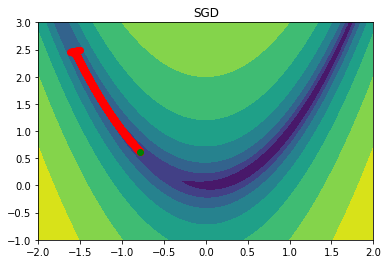

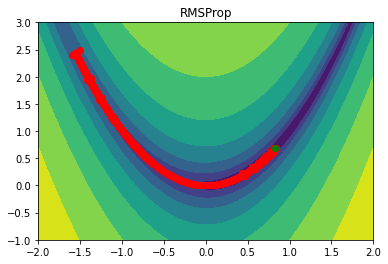

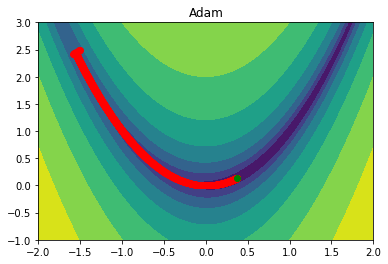

In [ ]:

optimizers = [("SGD", SGD), ("RMSProp", RMSProp), ("Adam", Adam)]

for name, opt_class in optimizers:
    xy = torch.tensor([-1.5,2.5], requires_grad=True)
    # xy.retain_grad()
    optimizer = opt_class(params=[xy])
    xys = opt_rosenbrock(xy=xy, lr=0.0005, momentum=0.9, n_iter=1200, optimizer=optimizer)
    figure, axis = plt.subplots(1, 1)
    axis.contourf(xs, ys, np.log(results))
    axis.scatter(xys[:,0], xys[:,1], c="red")
    axis.scatter(xys[-1,0], xys[-1,1], c="green")
    plt.title(name)
    plt.show()

In [ ]:
for name, opt_class in optimizers:
    xy = torch.tensor([-1.5,2.5], requires_grad=True)
    # xy.retain_grad()
    optimizer = opt_class(params=[xy])
    xys = opt_rosenbrock(xy=xy, lr=0.0005, momentum=0.9, n_iter=1200, optimizer=optimizer)
    figure, axis = plt.subplots(1, 1)
    axis.contourf(xs, ys, np.log(results))
    axis.scatter(xys[:,0], xys[:,1], c="red")
    axis.scatter(xys[-1,0], xys[-1,1], c="green")
    plt.title(name)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


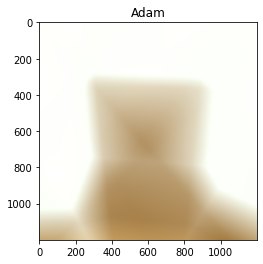

In [ ]:
optimizers = [("SGD", SGD), ("RMSProp", RMSProp), ("Adam", Adam)]

for name, opt_class in optimizers:
    model = MLP(2, 400, 3)
    model, training_losses, test_losses = train(model, data_train, data_test, optimizer = opt_class(model.parameters()))
    image = torch.zeros(height, width, 3)
    model.eval()
    for i in range(height):
        x = i / height - .5
        for j in range(width):
            y = j / width - .5
            with torch.no_grad():
                output = model(torch.Tensor([x,y]))
                image[i,j,:] = output + .5
    plt.title(name)
    plt.imshow(image.detach().numpy())

In [ ]:
import gin
gin.enter_interactive_mode()
@gin.configurable
def newtrain(image_name, learning_rate, momentum, epochs, optimizer, loss, hidden_size, weight_decay):
    model = MLP(2, hidden_size, 3)
    data_train, data_test =  w1d4_tests.load_image(image_name)
    if optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer == "rmsprop":
        optimizer = RMSProp(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
    else:
        optimizer = SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
    if loss == "mae":
        loss_f = F.l1_loss
    else:
        loss_f = nn.MSELoss()
    training_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        _training_losses = []
        for input, target in data_train:
            optimizer.zero_grad()
            output = model(input)
            loss = loss_f(output, target)
            _training_losses.append(loss.item())
            loss.backward()
            optimizer.step()
        test_loss = evaluate(model, data_test)
        test_losses.append(test_loss)  
        training_losses.append(sum(_training_losses) / len(_training_losses))
    return model, training_losses, test_losses

with gin.unlock_config():
    gin.parse_config_file(config_file="./config.gin")
    _, training_losses, test_losses = newtrain()
    print(training_losses, test_losses)

[0.046914559352444485, 0.03419608628610149, 0.031809512176550925, 0.030380073032574728, 0.02947170694824308, 0.027741142053855583, 0.026164896742557175, 0.024776093137916178, 0.023636287849512883, 0.023778104572556913, 0.02240028568485286, 0.022388434837921523, 0.021497014589840546, 0.020876724636764266, 0.021133996022399515, 0.020024153374833986] [0.1433806326240301, 0.13177494145929813, 0.12493534851819277, 0.12200769782066345, 0.12125112116336823, 0.13675137609243393, 0.10932325758039951, 0.11316265538334846, 0.10056581720709801, 0.09844747092574835, 0.11121077463030815, 0.09719759505242109, 0.10066815745085478, 0.09609045460820198, 0.1006024731323123, 0.10122343804687262]


In [ ]:
def make_grid(possible_values):
    grid = []
    total_size = 1
    for values in possible_values.values():
        total_size *= len(values)
    for i in range(total_size):
        assignment = {}
        for name, values in possible_values.items():
            values_i = i % len(values)
            assignment[name] = values[values_i]
            i //= len(values)
        grid.append(assignment)
    return grid

grid_values = {
  "train.lr":          np.geomspace(1e-1, 1e-3, 3),
  "Model.hidden_size": [768, 1024],
}

def job_str(job_dict):
    return "\n".join([f"{k} = {v}" for k, v in job_dict.items()])

def write_gin_file(job_dict, filename):
    with open(filename, "w") as ginfile:
        ginfile.write(job_str(job_dict))
        
def make_grid_with_files(possible_values):
    grid = make_grid(possible_values)
    for i, job in enumerate(grid):
        filename = f"config_{i}.gin"
        write_gin_file(job, filename)

make_grid_with_files(grid_values)